In [1]:
import os
import re
import random
import string

dataset_folder_name = "asl_dataset"
dataset_directory = os.path.join(os.getcwd(), "AlphabetDataset", dataset_folder_name)
def generate_random_filename(existing_filenames, extension):
    """Generate a unique random filename."""
    while True:
        random_name = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) + extension
        if random_name not in existing_filenames:
            return random_name

def rename_images_in_folders(dataset_path):
    # Iterate through each folder inside the dataset
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        # Check if it is a directory and not a hidden/system folder
        if not os.path.isdir(folder_path) or folder.startswith("."):
            continue
        
        # List all files
        files = sorted(os.listdir(folder_path))
        existing_filenames = set()
        
        # First rename all files to random names
        temp_filenames = {}
        for file in files:
            old_file_path = os.path.join(folder_path, file)
            
            # Skip directories
            if not os.path.isfile(old_file_path):
                continue
            
            # Get file extension
            file_extension = os.path.splitext(file)[1] or ".jpeg"
            
            # Generate unique random name
            random_name = generate_random_filename(existing_filenames, file_extension)
            new_temp_path = os.path.join(folder_path, random_name)
            
            os.rename(old_file_path, new_temp_path)
            existing_filenames.add(random_name)
            temp_filenames[random_name] = file  # Keep track of renamed files
        
        # Now rename files to the correct format, starting from 1 without checking past collisions
        next_number = 1
        for temp_file in sorted(temp_filenames.keys()):
            temp_file_path = os.path.join(folder_path, temp_file)
            
            new_file_name = f"_{folder}_{next_number}.jpeg"
            new_file_path = os.path.join(folder_path, new_file_name)
            os.rename(temp_file_path, new_file_path)
            print(f"Renamed {temp_file} -> {new_file_name}")
            
            next_number += 1  # Increment for next file
        
        print(f"Renaming completed for folder: {folder}")

# Automatically detect dataset directory path based on current working directory

rename_images_in_folders(dataset_directory)

print("Renaming complete!")


Renamed 01wwkeFr.jpeg -> _a_1.jpeg
Renamed 045lLEHe.jpeg -> _a_2.jpeg
Renamed 0Jj47mAq.jpg -> _a_3.jpeg
Renamed 0TQa30Zu.jpeg -> _a_4.jpeg
Renamed 0VY2clP1.jpg -> _a_5.jpeg
Renamed 0iMTYInm.jpeg -> _a_6.jpeg
Renamed 0kqnhoCi.jpg -> _a_7.jpeg
Renamed 0nWfxzx4.jpg -> _a_8.jpeg
Renamed 0yuJL5rR.jpeg -> _a_9.jpeg
Renamed 12apgme8.jpeg -> _a_10.jpeg
Renamed 17jic4Bc.jpeg -> _a_11.jpeg
Renamed 1BnN3DfM.jpeg -> _a_12.jpeg
Renamed 1E8XtWSq.jpeg -> _a_13.jpeg
Renamed 1WtTusOP.jpeg -> _a_14.jpeg
Renamed 1XtzFIXf.jpeg -> _a_15.jpeg
Renamed 24Zz2D8c.jpeg -> _a_16.jpeg
Renamed 2D9fzGJf.jpeg -> _a_17.jpeg
Renamed 2ITb94ji.jpg -> _a_18.jpeg
Renamed 2aUlEJcz.jpg -> _a_19.jpeg
Renamed 2lpIrCFw.jpg -> _a_20.jpeg
Renamed 3Q6utCXV.jpeg -> _a_21.jpeg
Renamed 3RGRrmcm.jpeg -> _a_22.jpeg
Renamed 3kPFkjV4.jpeg -> _a_23.jpeg
Renamed 3m5uQQhQ.jpg -> _a_24.jpeg
Renamed 3ol6G2sS.jpeg -> _a_25.jpeg
Renamed 3wvzjKRk.jpeg -> _a_26.jpeg
Renamed 3zW3OBtF.jpg -> _a_27.jpeg
Renamed 42noEtN7.jpeg -> _a_28.jpeg
Renamed 4A

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import joblib
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Paths
DATASET_PATH = dataset_directory

# Verify if the dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

LABELS = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Function to extract label from filename
def extract_label_from_filename(filename):
    match = re.search(r'_([a-z0-9])_', filename)
    return match.group(1) if match else None

# Function to extract hand landmarks
def extract_landmarks(image_path):
    if not os.path.isfile(image_path):
        return None  # Ensure we only process files
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load image {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

        # Extract relative path
        relative_path = os.path.relpath(image_path, DATASET_PATH)
        print(f"Successfully extracted landmarks from: {relative_path}")  # Debugging output
        return landmarks
    return None

# Prepare dataset
X, y = [], []
Label_List = []
Label_Count = []
Label_FailCount = []
for label in LABELS:
    Label_List.append(label)
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        failCount = 0
        count = 0
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            if not os.path.isfile(img_path):
                continue  # Skip directories
            extracted_label = extract_label_from_filename(img_file)
            if extracted_label:
                landmarks = extract_landmarks(img_path)
                if landmarks:
                    X.append(landmarks)
                    y.append(extracted_label)
                    count = count + 1
                    # Extract relative path
                    relative_path = os.path.relpath(img_path, DATASET_PATH)
                    print(f"File used for training: {relative_path} - Label: {extracted_label}")  # Debugging output
                else:
                    failCount = failCount + 1
        Label_Count.append(count)
        Label_FailCount.append(failCount)


Successfully extracted landmarks from: a\_a_1.jpeg
File used for training: a\_a_1.jpeg - Label: a
Successfully extracted landmarks from: a\_a_10.jpeg
File used for training: a\_a_10.jpeg - Label: a
Successfully extracted landmarks from: a\_a_100.jpeg
File used for training: a\_a_100.jpeg - Label: a
Successfully extracted landmarks from: a\_a_101.jpeg
File used for training: a\_a_101.jpeg - Label: a
Successfully extracted landmarks from: a\_a_103.jpeg
File used for training: a\_a_103.jpeg - Label: a
Successfully extracted landmarks from: a\_a_104.jpeg
File used for training: a\_a_104.jpeg - Label: a
Successfully extracted landmarks from: a\_a_105.jpeg
File used for training: a\_a_105.jpeg - Label: a
Successfully extracted landmarks from: a\_a_107.jpeg
File used for training: a\_a_107.jpeg - Label: a
Successfully extracted landmarks from: a\_a_108.jpeg
File used for training: a\_a_108.jpeg - Label: a
Successfully extracted landmarks from: a\_a_109.jpeg
File used for training: a\_a_109.jp

In [3]:
totalTrainedSuccess = 0
for i in range(0, len(Label_Count)):
    totalTrainedSuccess = totalTrainedSuccess + Label_Count[i]
print("Total Photo Sucessfully Trained:", totalTrainedSuccess)
for i in range(0, len(Label_Count)):
    print(f"Label{Label_List[i]}:  LandMarkSuccess = {Label_Count[i]}, LandMarkFail = {Label_FailCount[i]}")

Total Photo Sucessfully Trained: 6933
Labela:  LandMarkSuccess = 274, LandMarkFail = 62
Labelb:  LandMarkSuccess = 247, LandMarkFail = 17
Labelc:  LandMarkSuccess = 311, LandMarkFail = 73
Labeld:  LandMarkSuccess = 240, LandMarkFail = 39
Labele:  LandMarkSuccess = 303, LandMarkFail = 84
Labelf:  LandMarkSuccess = 309, LandMarkFail = 15
Labelg:  LandMarkSuccess = 224, LandMarkFail = 34
Labelh:  LandMarkSuccess = 400, LandMarkFail = 2
Labeli:  LandMarkSuccess = 318, LandMarkFail = 30
Labelj:  LandMarkSuccess = 284, LandMarkFail = 70
Labelk:  LandMarkSuccess = 324, LandMarkFail = 9
Labell:  LandMarkSuccess = 221, LandMarkFail = 13
Labelm:  LandMarkSuccess = 220, LandMarkFail = 131
Labeln:  LandMarkSuccess = 111, LandMarkFail = 69
Labelo:  LandMarkSuccess = 288, LandMarkFail = 66
Labelp:  LandMarkSuccess = 315, LandMarkFail = 60
Labelq:  LandMarkSuccess = 229, LandMarkFail = 77
Labelr:  LandMarkSuccess = 308, LandMarkFail = 28
Labels:  LandMarkSuccess = 430, LandMarkFail = 71
Labelt:  Land

In [4]:
# Combine Label_List, Label_Count, and Label_FailCount
sorted_labels = sorted(zip(Label_Count, Label_List, Label_FailCount))

# Print the sorted labels
for success, label, fail in sorted_labels:
    print(f"Label {label}: LandMarkSuccess = {success}, LandMarkFail = {fail}")


Label t: LandMarkSuccess = 89, LandMarkFail = 68
Label n: LandMarkSuccess = 111, LandMarkFail = 69
Label z: LandMarkSuccess = 166, LandMarkFail = 20
Label x: LandMarkSuccess = 216, LandMarkFail = 117
Label m: LandMarkSuccess = 220, LandMarkFail = 131
Label l: LandMarkSuccess = 221, LandMarkFail = 13
Label g: LandMarkSuccess = 224, LandMarkFail = 34
Label q: LandMarkSuccess = 229, LandMarkFail = 77
Label u: LandMarkSuccess = 239, LandMarkFail = 43
Label d: LandMarkSuccess = 240, LandMarkFail = 39
Label b: LandMarkSuccess = 247, LandMarkFail = 17
Label y: LandMarkSuccess = 258, LandMarkFail = 42
Label a: LandMarkSuccess = 274, LandMarkFail = 62
Label j: LandMarkSuccess = 284, LandMarkFail = 70
Label o: LandMarkSuccess = 288, LandMarkFail = 66
Label v: LandMarkSuccess = 297, LandMarkFail = 45
Label e: LandMarkSuccess = 303, LandMarkFail = 84
Label r: LandMarkSuccess = 308, LandMarkFail = 28
Label f: LandMarkSuccess = 309, LandMarkFail = 15
Label c: LandMarkSuccess = 311, LandMarkFail = 73

In [5]:

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Ensure dataset is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid hand landmarks found in dataset. Check dataset structure.")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, 'asl_rf_model.pkl')
print("Model saved as asl_rf_model.pkl")

# Evaluate Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')


Model saved as asl_rf_model.pkl
Model Accuracy: 0.95


✅ Model file found. Loading...


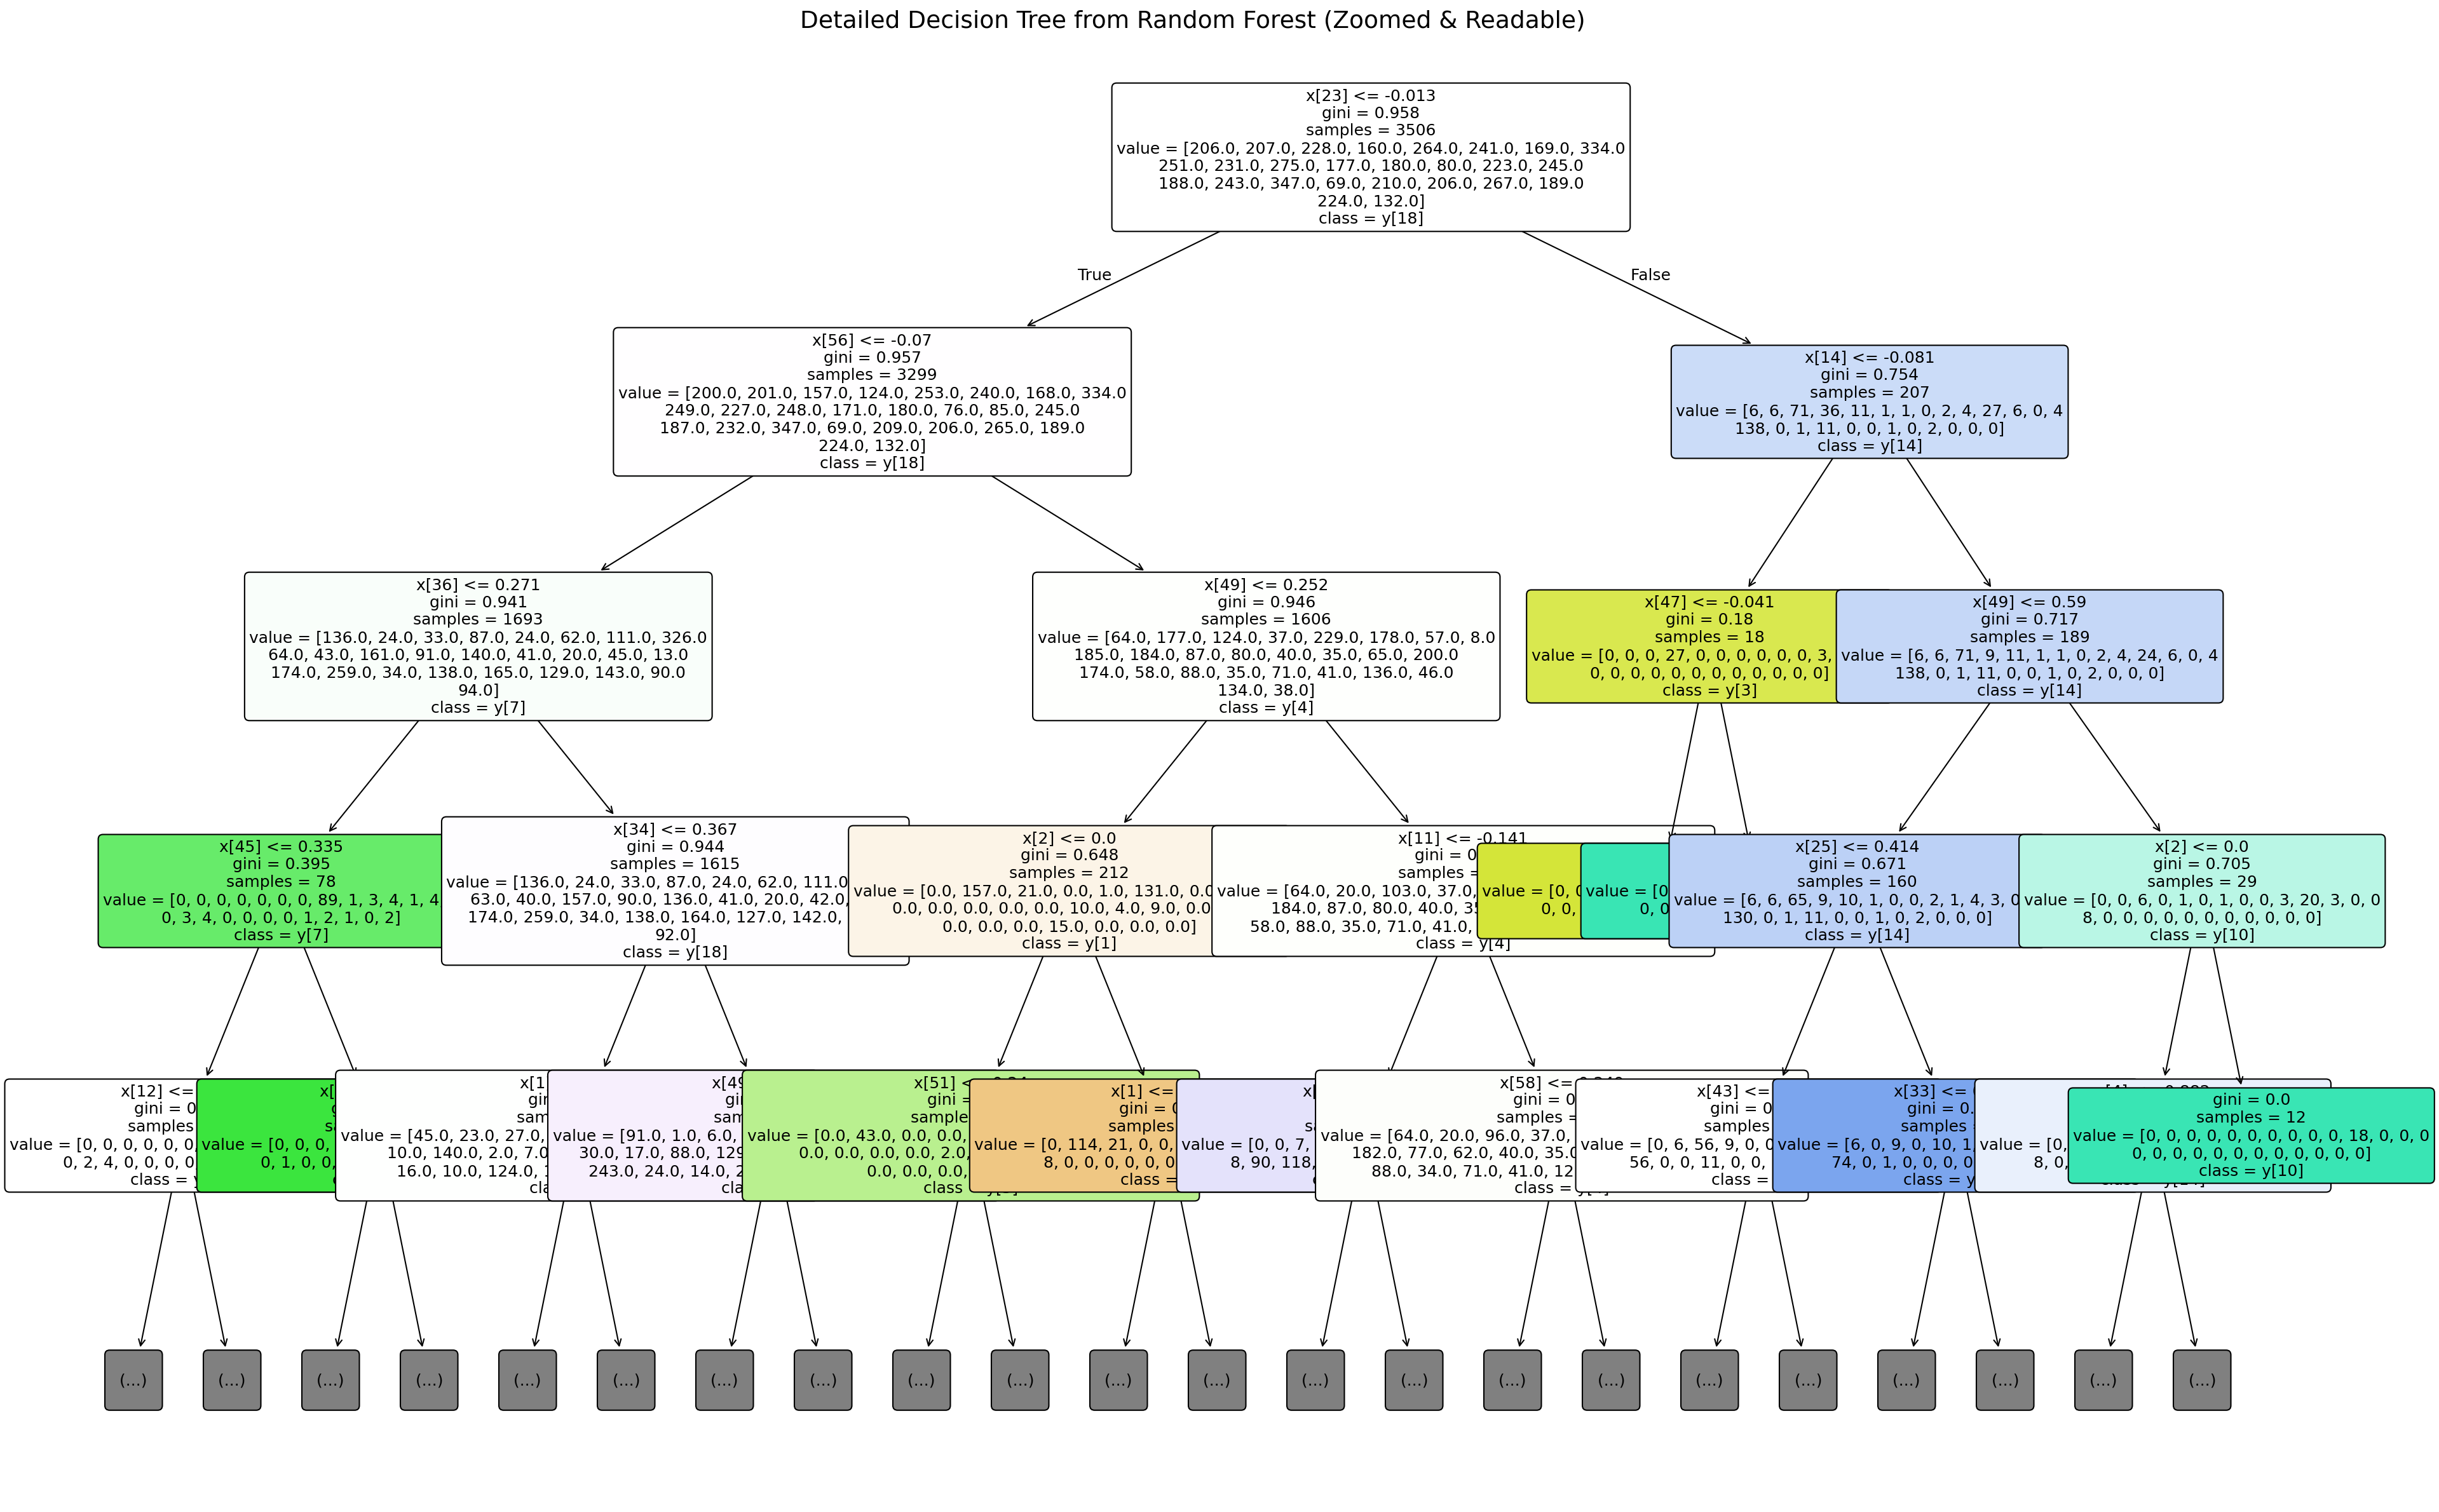

In [6]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define model path
model_path = os.path.join(os.getcwd(), "asl_rf_model.pkl")
# Check if model exists
if os.path.exists(model_path):
    print("✅ Model file found. Loading...")
else:
    print("❌ Model file NOT found. Check the file path!")
    exit()

# Load the trained Random Forest model
clf = joblib.load(model_path)

# Select a single decision tree from the Random Forest
tree = clf.estimators_[0]  # First tree in the forest

# Generate a large and detailed decision tree visualization
plt.figure(figsize=(30, 20), dpi=150)  # Increased figure size

plot_tree(
    tree, 
    filled=True, 
    feature_names=None,  # Replace with actual feature names if available
    class_names=True, 
    rounded=True, 
    fontsize=12,  # Larger font size for readability
    max_depth=4  # Limit depth to keep it readable (adjustable)
)

plt.title("Detailed Decision Tree from Random Forest (Zoomed & Readable)", fontsize=18)
plt.show()


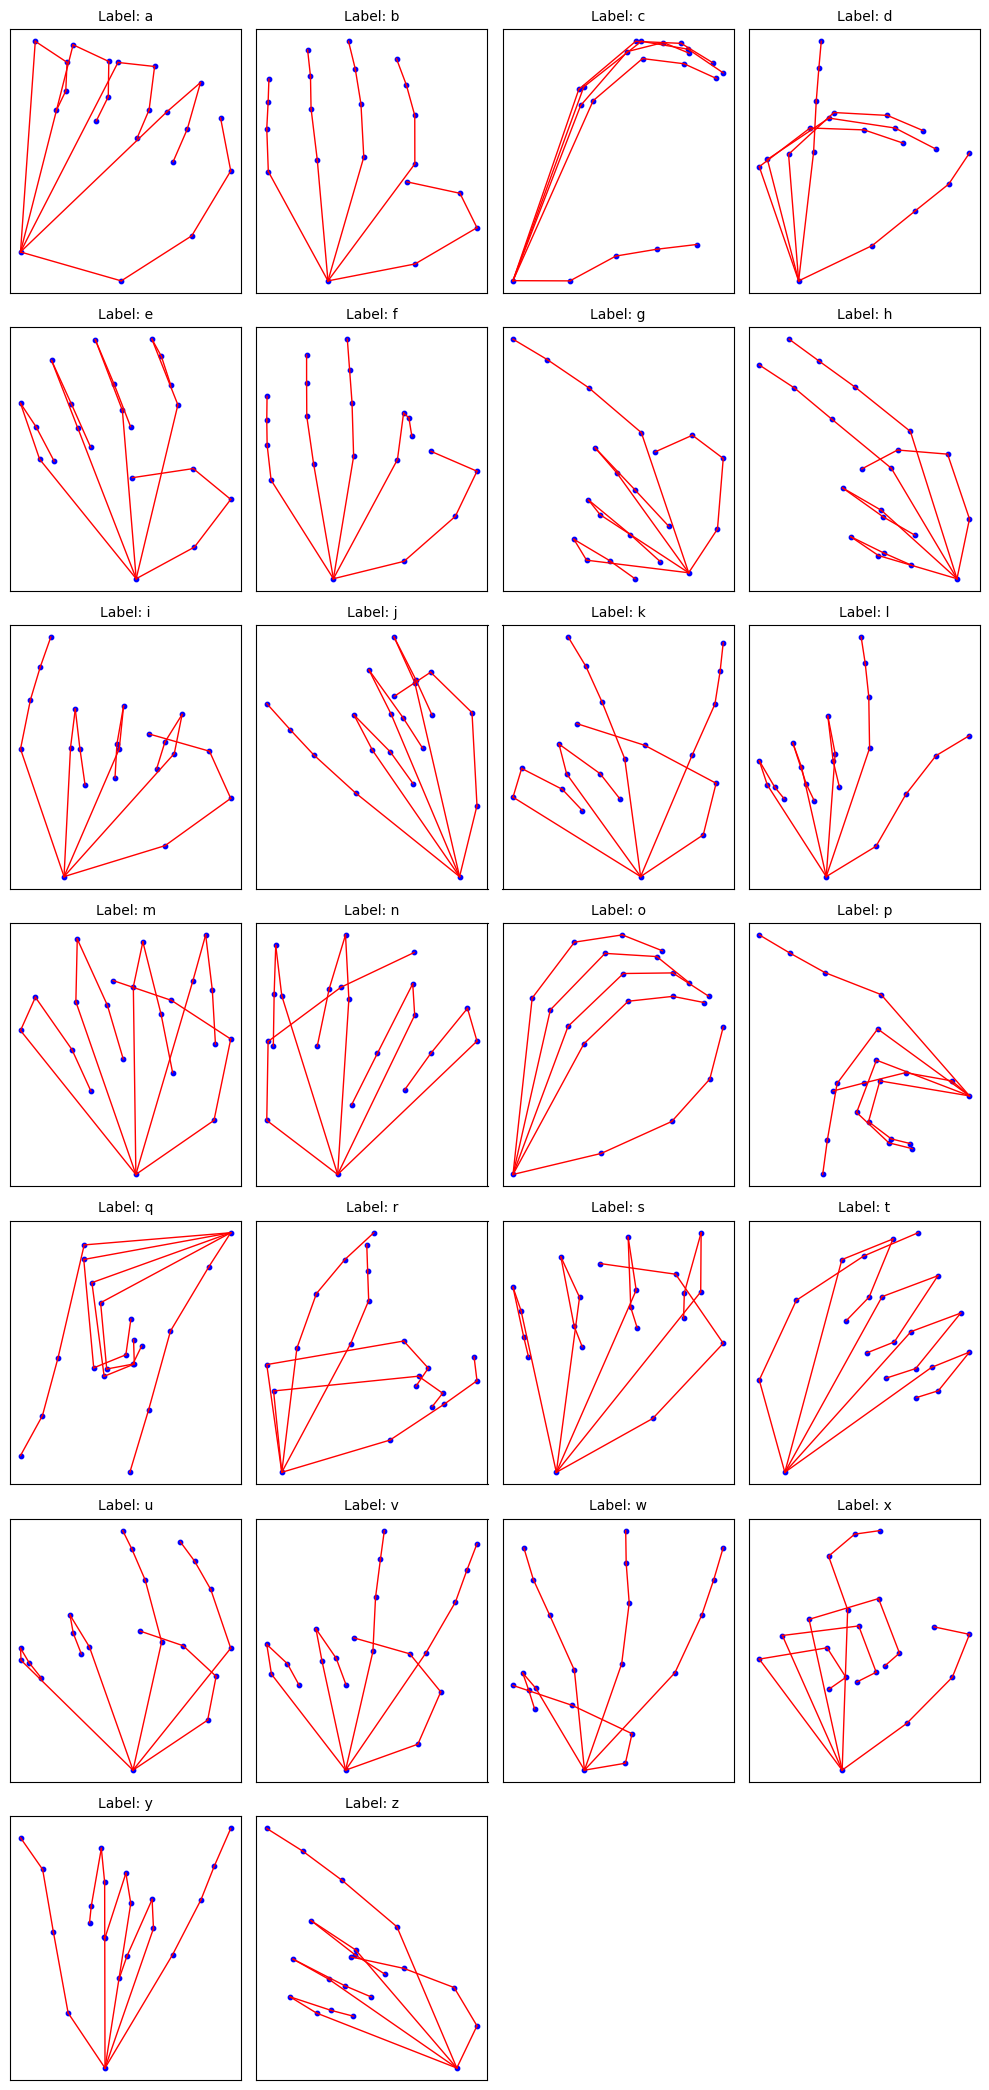

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to extract and store landmarks as numerical values

def extract_landmark_values(landmarks, label):
    if landmarks is None:
        return None
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    # Store landmarks as a list of dictionaries
    landmark_data = {
        "label": label,
        "landmarks": [{"x": lm[0], "y": lm[1], "z": lm[2]} for lm in landmarks],
        "connections": [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                        (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky
    }
    
    return landmark_data

# Function to visualize landmarks
def plot_landmarks(ax, landmarks, label):
    if landmarks is None:
        ax.set_title(f"No landmarks for {label}")
        ax.axis("off")
        return
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    ax.scatter(landmarks[:, 0], -landmarks[:, 1], c='blue', s=10)  # Smaller points
    
    # Define connections based on MediaPipe hand structure
    connections = [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                   (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                   (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                   (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                   (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky

    for start, end in connections:
        ax.plot([landmarks[start, 0], landmarks[end, 0]],
                 [-landmarks[start, 1], -landmarks[end, 1]], 'r-', linewidth=1)

    ax.set_title(f"Label: {label}", fontsize=10)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Store landmark data for each label
landmark_data_list = []

unique_labels = sorted(set(y))  # Extract unique labels from dataset

num_labels = len(unique_labels)
num_cols = 4  # 4 plots per row
num_rows = max(1, (num_labels + num_cols - 1) // num_cols)  # Ensure at least 1 row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    idxs = np.where(y == label)[0]
    if len(idxs) == 0:
        continue  # Skip if no landmarks for this label
    idx = idxs[0]  # Get first occurrence of label
    
    # Extract numerical values
    landmark_values = extract_landmark_values(X[idx], label)
    if landmark_values:
        landmark_data_list.append(landmark_values)
    
    # Plot visualization
    plot_landmarks(axes[i], X[idx], label)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()





In [8]:
# Save landmarks as JSON file
with open('hand_landmarks_data.json', 'w') as json_file:
    json.dump(landmark_data_list, json_file, indent=4)

print("\n✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.\n")

# Optional: Display numerical values in a readable format
for idx, data in enumerate(landmark_data_list):
    print("=" * 40)
    print(f"📌 Label: {data['label']}")
    print(f"🖐 Total Landmarks: {len(data['landmarks'])}")
    print("=" * 40)

    # Print landmark coordinates in a structured way
    print(f"{'Index':<6} {'X':<10} {'Y':<10} {'Z':<10}")
    print("-" * 40)
    for i, lm in enumerate(data["landmarks"]):
        print(f"{i:<6} {lm['x']:<10.5f} {lm['y']:<10.5f} {lm['z']:<10.5f}")

    print("\n🔗 Connections:")
    for conn in data["connections"]:
        print(f"({conn[0]} → {conn[1]})", end="  ")
    
    print("\n" + "=" * 40 + "\n")




✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.

📌 Label: a
🖐 Total Landmarks: 21
Index  X          Y          Z         
----------------------------------------
0      0.35366    0.61687    -0.00000  
1      0.57960    0.65478    0.02512   
2      0.73773    0.59567    0.03570   
3      0.82523    0.51055    0.04663   
4      0.80234    0.44084    0.05879   
5      0.68185    0.43303    -0.01285  
6      0.75744    0.39460    0.00858   
7      0.72777    0.45568    0.02175   
8      0.69606    0.49837    0.02705   
9      0.57233    0.36825    -0.01924  
10     0.65440    0.37354    0.03158   
11     0.64208    0.43045    0.05152   
12     0.61510    0.46754    0.04723   
13     0.47164    0.34507    -0.01728  
14     0.55175    0.36697    0.04114   
15     0.55048    0.41320    0.05917   
16     0.52369    0.44491    0.04869   
17     0.38677    0.34051    -0.01361  
18     0.45802    0.36808    0.03814   
19     0.45520    0.40556    0.06700   
20     0.43

In [9]:
import cv2
import mediapipe as mp
import numpy as np
import joblib

# Load Model
model_name = "asl_rf_model.pkl"
model_directory = os.path.join(os.getcwd(),  model_name)
clf = joblib.load(model_directory)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles  # For better visualization
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract hand landmarks from webcam frame
def extract_landmarks_from_frame(frame, results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return np.array(landmarks).reshape(1, -1)  # Return the reshaped array
    return None

# Start Webcam Capture
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Extract landmarks and predict
    landmarks = extract_landmarks_from_frame(frame, results)
    if landmarks is not None:
        prediction = clf.predict(landmarks)[0]
        cv2.putText(frame, f'Predicted: {prediction.upper()}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

    # Show the output frame
    cv2.imshow('ASL Detection', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
